# Titanic Survival with DNN

**Predicting survival on the Titanic using an artificial neural network in Keras**


**Supervised Learning. Binary classification**


This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. A description of this dataset is on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.

In [29]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ds_boost
import keras

log = ds_boost.logger.init(level="DEBUG", save_log=False)

ds_boost.set_parent_execution_path()
ds_boost.info_system()
ds_boost.reproducible(seed=0)  # Setup reproducible results from run to run using Keras

%matplotlib inline

23:40:12 - DEBUG 	 Already in target path /home/angel/DRIVE/0_repos/data-science-keras
23:40:12 - DEBUG 	 HARDWARE:
23:40:13 - DEBUG 	 CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
23:40:13 - DEBUG 	 RAM:	15 GB
23:40:13 - DEBUG 	 -- No GPU  --
23:40:13 - DEBUG 	 OS:	Linux-5.15.0-57-generic-x86_64-with-glibc2.35
23:40:13 - DEBUG 	 ENV:	/home/angel/miniconda3/envs/ds-keras
23:40:13 - DEBUG 	 PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
23:40:13 - DEBUG 	 tensorflow                   2.11.0
23:40:13 - DEBUG 	 pandas                        1.5.2
23:40:13 - DEBUG 	 numpy                        1.24.1
23:40:13 - DEBUG 	 EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
23:40:13 - DEBUG 	 EXECUTION DATE: Mon Jan 16 23:40:13 2023


## 1. Data Processing and Exploratory Data Analysis

In [30]:
data_path = "data/titanic_data.csv"
target = ["Survived"]  # the target will remain the same throughout the notebook

df_original = pd.read_csv(data_path)
print("{} rows \n{} columns \ntarget: {}".format(*df_original.shape, target))

891 rows 
12 columns 
target: ['Survived']


### Show the data

In [31]:
df_original.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Numerical Data

In [32]:
df_original.describe(percentiles=[0.5])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Non-numerical Data

In [33]:
df_original.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


#### Missing values

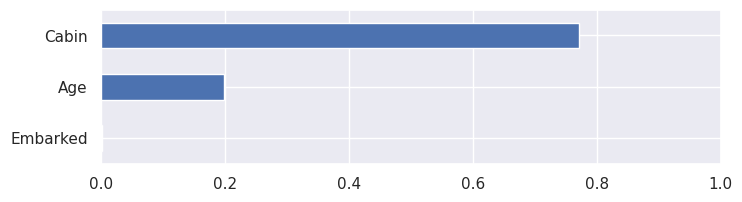

In [34]:
ds_boost.missing(df_original)

- Binary target "Survived": ~38% ones; F1 score won't be used <br>
- Some values are missing for key values (e.g. Age)
- Some features (e.g. PassengerID, Name, Ticket) seem irelevant to survival probabilities <br> 

### Transform the data

#### Enhance and add new features

In [35]:
df = df_original.copy()  # modified dataset


def enhance_features(df, dict_categories=None):
    """Enhance dataframe df"""
    df = df.copy()
    # filter Cabin to first letter
    df["Cabin"] = df["Cabin"].str[0]
    # get Title from Name
    df["Title"] = df["Name"].str.extract("([A-Za-z]+)\.", expand=False)
    # remove low frequency values for the new features
    fields = ["Cabin", "Title"]
    df, dict_categories = ds_boost.remove_categories(df, target=target, show=False)
    # Alone passenger
    df["Alone"] = ((df["SibSp"] + df["Parch"]) == 0).astype(int)
    return df, dict_categories


df, dict_categories = enhance_features(df)

23:40:14 - DEBUG 	 Variables changed to 'category': {columns_to_convert}
23:40:14 - DEBUG 	 Removing 891 categories from feature Name
23:40:14 - DEBUG 	 Removing 681 categories from feature Ticket
23:40:14 - DEBUG 	 Removing 2 categories from feature Cabin
23:40:14 - DEBUG 	 Removing 13 categories from feature Title


#### Remove irrelevant features

In [36]:
def drop_irrelevant_features(df, inplace=False):
    """Remove non-relevant columns from dataframe df (inplace)"""
    if not inplace:
        df = df.copy()
    df.drop(["PassengerId", "Name", "Ticket"], axis="columns", inplace=True)
    if not inplace:
        return df


drop_irrelevant_features(df, inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [37]:
df = ds_boost.sort_columns_by_type(df, target, numerical=["Age", "SibSp", "Parch", "Fare"])

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

23:40:14 - DEBUG 	 4 numerical features: 	 ['Age', 'SibSp', 'Parch', 'Fare']
23:40:14 - DEBUG 	 6 categorical features: 	 ['Embarked', 'Cabin', 'Sex', 'Title', 'Pclass', 'Alone']
23:40:14 - DEBUG 	 Target: 		Survived (int64)


,Age,SibSp,Parch,Fare,Embarked,Cabin,Sex,Title,Pclass,Alone,Survived
Type,float32,float32,float32,float32,category,category,category,category,category,category,int64


### Visualize the data

#### Categorical features

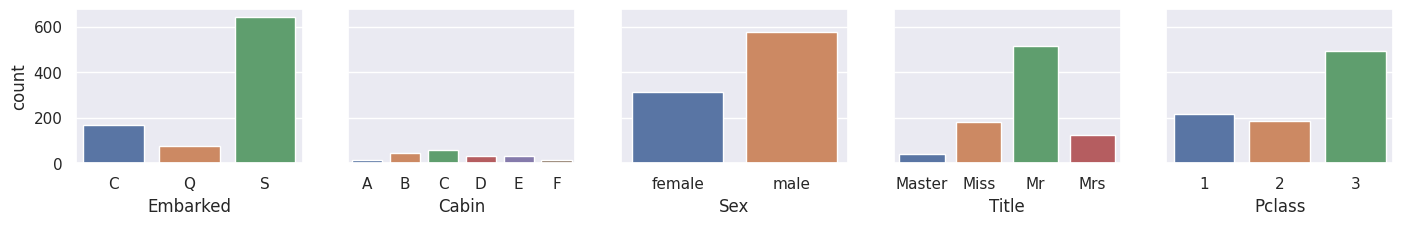

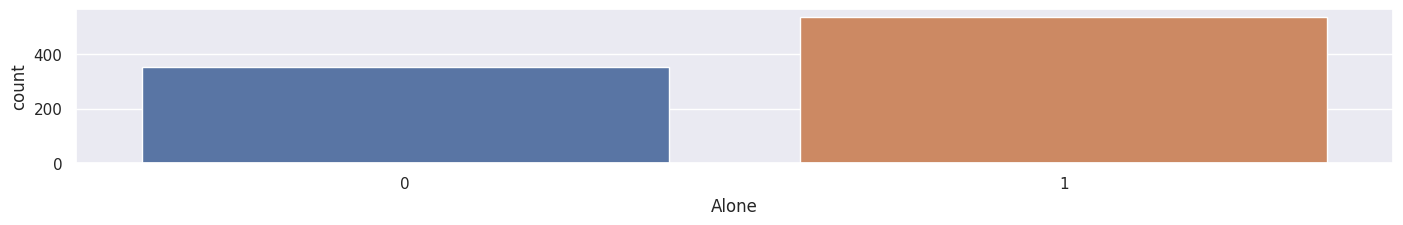

In [38]:
ds_boost.show_categorical(df, target=target, sharey=True)

#### Target vs Categorical features

In [39]:
# ds_boost.show_target_vs_categorical(df, target)
# plt.ylim([0, 1]);

#### Numerical features

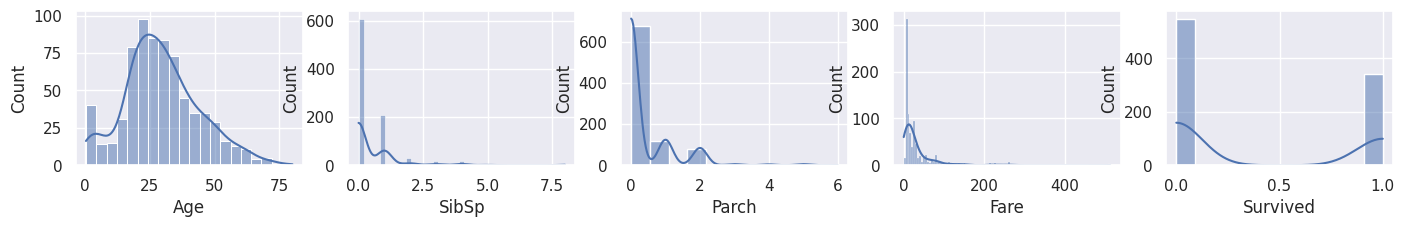

In [40]:
ds_boost.show_numerical(df, kde=True)

#### Target vs numerical features

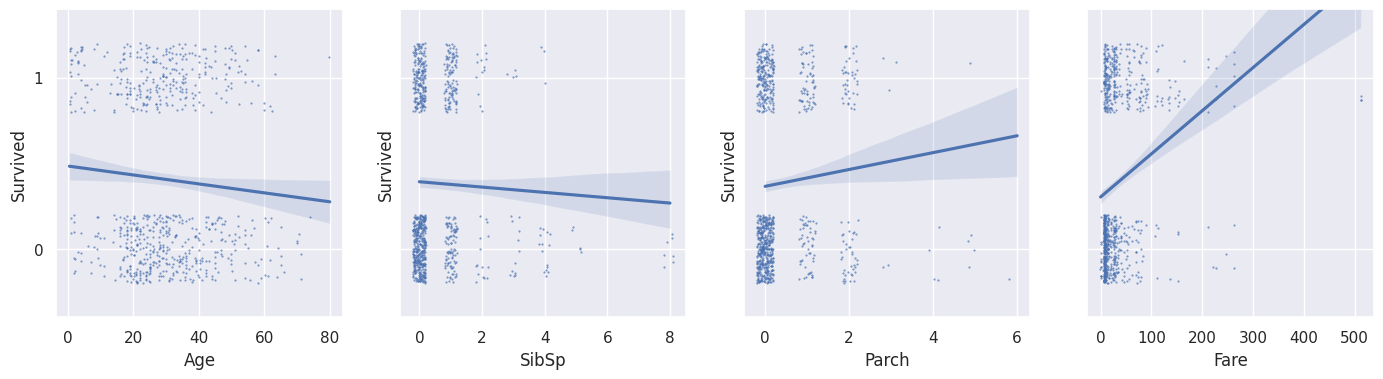

In [41]:
ds_boost.show_target_vs_numerical(df, target, jitter=0.2)
plt.ylim([-0.4, 1.4])
plt.yticks([0, 1]);
# df.groupby('Survived')['Age'].hist(alpha=0.4)
# ds_boost.show_target_vs_numerical(df_3sigma, target, numerical, jitter=0.2)

#### Correlation between numerical features and target

/home/angel/DRIVE/0_repos/data-science-keras/src/ds_boost/ds_boost.py:778: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = copy_df.corr().loc[numerical_f, target].fillna(0).sort_values(target, ascending=False).round(2)


[]

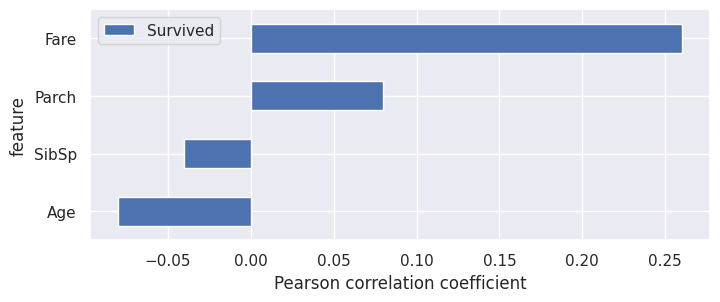

In [42]:
ds_boost.correlation(df, target)

#### Most relevant features

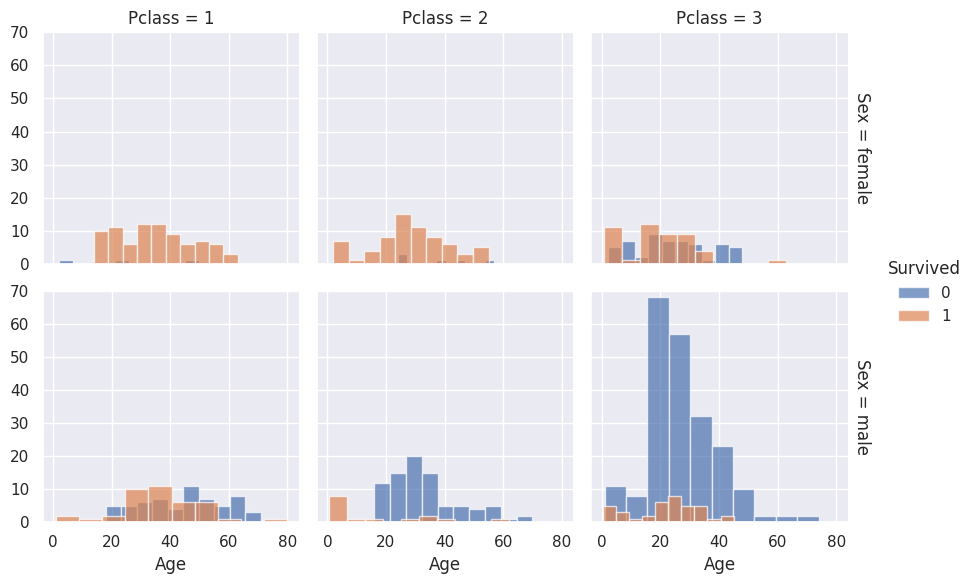

In [43]:
sns.FacetGrid(df, row="Sex", col="Pclass", hue="Survived", margin_titles=True).map(
    plt.hist, "Age", alpha=0.7
).add_legend()
plt.ylim([0, 70]);
# df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(
#     by='Survived', ascending=False)
# ds_boost.show_target_vs_categorical(df.loc[(df['Age']<12) | (df['Sex']=='female')],
#                                   target, categorical)

-  Unlike in third class, most children and women in first and second classes survived.

### Fill missing values

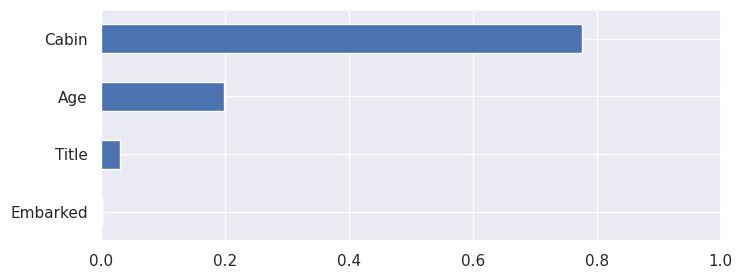

In [44]:
ds_boost.missing(df)

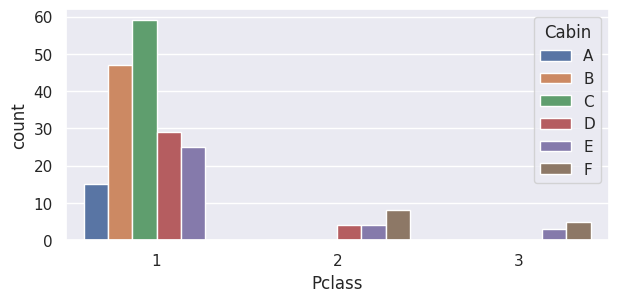

In [45]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df, x="Pclass", hue="Cabin");

In [46]:
# ds_boost.show_target_vs_categorical(df, ["Age"], figsize=(17, 2))  # Age vs categorical

In [47]:
def fill_missing_values(df, inplace=False):
    """Fill missing values of the dataframe df"""

    if not inplace:
        df = df.copy()

    # fill Embarked with mode
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

    # fill Cabin: the mode for grouped Pclass and Embarked
    ref = df.groupby(["Pclass", "Embarked"])["Cabin"].transform(lambda x: x.mode()[0])
    df["Cabin"].fillna(ref.iloc[0], inplace=True)

    # fill Age: the median for grouped Pclass and Title
    ref = df.groupby(["Pclass", "Title"])["Age"].transform("median")
    df["Age"].fillna(ref, inplace=True)

    # fill Title: by age and sex only (not spouse or job)
    # df.loc[df['Title']=='Master','Age'].unique()
    #     for idx, row in df.iterrows():
    #         if (pd.isnull(row['Title'])):
    #             if row['Age'] >= 13:
    #                 if row['Sex'] == 'male':
    #                     df.loc[idx, 'Title'] = "Mr"
    #                 else:
    #                     df.loc[idx, 'Title'] = "Mrs"
    #             else:
    #                 if row['Sex'] == 'male':
    #                     df.loc[idx, 'Title'] = "Master"
    #                 else:
    #                     df.loc[idx, 'Title'] = "Miss"

    # fill missing categorical values with the mode (if any)
    categorical = list(df.select_dtypes(include=["category"]))
    modes = df[categorical].mode()  # this solves fillna issue with mode()
    for idx, f in enumerate(df[categorical]):
        df[f].fillna(modes.iloc[0, idx], inplace=True)

    # fill missing numeric NaN values with the median (if any)
    numerical = list(df.select_dtypes(include=["number"]))
    df[numerical] = df[numerical].fillna(df[numerical].median())

    if not inplace:
        return df


# bins = list(range(0,80,10))
# # bins = (0, 5, 10, 15, 20, 30, 40, 50, 60)
# labels = ["{}-{}".format(i, j) for i,j in zip(bins[:-1],bins[:-1])]
# df['Age_cat'] = pd.cut(df['Age'], bins, labels=labels).astype('category')
# df = df.drop(['Age'], axis='columns')

fill_missing_values(df, inplace=True)

## 2. Neural Network model

### Select the features

In [48]:
droplist = []  # features to drop from the model

# For the model 'data' instead of 'df'
data = df.copy()
df.drop(droplist, axis="columns", inplace=True)
data.head(3)

,Age,SibSp,Parch,Fare,Embarked,Cabin,Sex,Title,Pclass,Alone,Survived
0,22.0,1.0,0.0,7.250000,S,E,male,Mr,3,0,0
1,38.0,1.0,0.0,71.283302,C,C,female,Mrs,1,0,1
2,26.0,0.0,0.0,7.925000,S,E,female,Miss,3,1,1


### Scale numerical variables

Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [49]:
data, scale_param = ds_boost.scale(data)

### Create dummy features

Replace categorical features (no target) with dummy features

In [50]:
data, dict_dummies = ds_boost.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target]  # sorted neural network inputs

data.head(3)

,Age,SibSp,Parch,Fare,Survived,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,...,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Pclass_1,Pclass_2,Pclass_3,Alone_0,Alone_1
0,-0.528175,0.432550,-0.473408,-0.502163,-0.788829,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0
1,0.658128,0.432550,-0.473408,0.786404,1.266279,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,-0.231600,-0.474279,-0.473408,-0.488580,1.266279,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1


### Split the data into training and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [51]:
from sklearn.model_selection import train_test_split


def split(data, target, test_size=0.15):
    train, test = train_test_split(data, test_size=test_size, random_state=9, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_test, y_test = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = split(data, target, test_size=0.2)

### One-hot encode the output

In [52]:
def one_hot_output(y_train, y_test):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return y_train, y_test


y_train, y_test = one_hot_output(y_train, y_test)

print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(712, 24) 	 Y:(712, 2)
test size  	 X:(179, 24) 	 Y:(179, 2) 


### Build the Neural Network for Binary Classification

In [53]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):
    input_nodes = input_size
    weights = keras.initializers.RandomNormal(stddev=0.001)
    leaky_relu = keras.layers.LeakyReLU(alpha=0.01)

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            kernel_initializer=weights,
            activation="relu",
            bias_initializer="zero",
        )
    )
    model.add(leaky_relu)

    model.add(Dropout(0.3))

    model.add(
        Dense(
            output_size,
            activation="softmax",
            kernel_initializer=weights,
            bias_initializer="zero",
        )
    )

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    if summary:
        model.summary()

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                600       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24)                0         
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50        
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


### Train the Neural Network

Training ....
time: 	 2.2 s


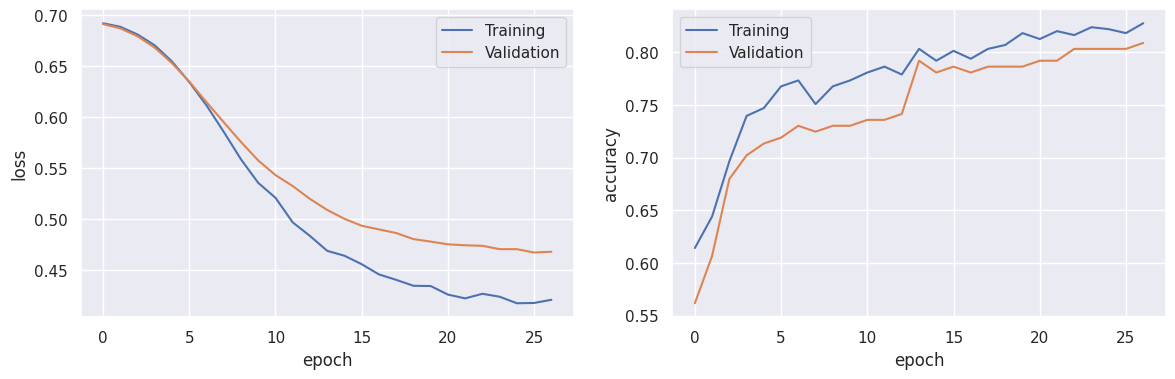

23:40:25 - DEBUG 	 Training loss:  	0.4209
23:40:25 - DEBUG 	 Validation loss: 	 0.4680
23:40:25 - DEBUG 	 Training accuracy: 	0.828
23:40:25 - DEBUG 	 Validation accuracy:	0.809

Model saved at models/titanic.h5


In [54]:
from time import time

model_path = os.path.join("models", "titanic.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """
    Train the neural network model. If no validation_data is provided, a split for validation
    will be used
    """

    if show:
        print("Training ....")

    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=1000,
        batch_size=64,
        verbose=0,
        validation_split=0.25,
        validation_data=validation_data,
        callbacks=callbacks,
    )

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        ds_boost.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)

    return history


model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=model_path);

### Train with Cross Validation

In [55]:
from sklearn.model_selection import StratifiedKFold


def cv_train_nn(x_train, y_train, n_splits):
    """Create and Train models for cross validation. Return best model"""

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_acc = 0

    print("Training {} models for Cross Validation ...".format(n_splits))

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
        history = train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]),
        )

        val_acc = history.history["val_accuracy"][-1]

        score.append(val_acc)

        if val_acc > best_acc:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_acc = val_acc

    model = best_model
    print("\nCross Validation accuracy: {:.3f}".format(np.mean(score)))

    return best_model


model = cv_train_nn(x_train, y_train, 4)

Training 4 models for Cross Validation ...


/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(



Cross Validation accuracy: 0.813


### Evaluate the model

In [56]:
def evaluate_nn(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test Accuracy: {:.3f}".format(score[1]))


# model = keras.models.load_model(model_path)
evaluate_nn(model, x_test, y_test)

Test Accuracy: 0.827


In [57]:
y_pred = model.predict(x_test, verbose=2)
ds_boost.binary_classification_scores(y_test[:, 1], y_pred[:, 1], return_dataframe=True, index="Neural Network")

6/6 - 0s - 85ms/epoch - 14ms/step
23:40:35 - DEBUG 	 Confusion matrix: 
 [[98 12]
 [19 50]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
Neural Network,0.52,0.83,0.81,0.72,0.86,0.76


### Make predictions

In [58]:
def predict_manual(new_df):
    """
    input: custom dataframe
    """

    new_data = new_df.copy()

    # force data types to previous dataframe df
    for col in new_data:
        new_data[col] = new_data[col].astype(df.dtypes[col])

    # standardize numerical variables
    new_data, _ = ds_boost.scale(new_data, scale_param)

    # replace categorical features by dummy variables (using existing dummies)
    new_data, _ = ds_boost.replace_by_dummies(new_data, target, dict_dummies)

    # sort columns to match with manual entries
    new_data = new_data[model_features]  ## model_features: sorted list used in the model

    # make predictions
    prediction = model.predict(new_data.values)[:, 1]
    return prediction

In [59]:
# input data format
df.describe()

,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.123648,0.523008,0.381594,32.204208,0.383838
std,13.487280,1.102744,0.806057,49.693428,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.910400,0.000000
50%,26.000000,0.000000,0.000000,14.454200,0.000000
75%,36.250000,1.000000,0.000000,31.000000,1.000000
max,80.000000,8.000000,6.000000,512.329224,1.000000


In [60]:
df.describe(include=["category"])

,Embarked,Cabin,Sex,Title,Pclass,Alone
count,891,891,891,891,891,891
unique,3,6,2,4,3,2
top,S,E,male,Mr,3,1
freq,646,724,577,544,491,537


In [61]:
print(list(df))

['Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Sex', 'Title', 'Pclass', 'Alone', 'Survived']


In [62]:
new_passengers = {
    "Average man": [26, 1, 0, 14, 2, "male", "C", "S", "Mr", 0],
    "Average woman": [26, 1, 0, 14, 2, "female", "C", "S", "Mrs", 0],
    "Alone woman 3c": [26, 0, 2, 8, 3, "female", "C", "S", "Miss", 1],
    "Boy 1c ": [7, 0, 2, 31, 1, "male", "C", "S", "Master", 0],
    "Boy 2c ": [7, 0, 2, 14, 2, "male", "C", "S", "Master", 0],
    "Boy 3c ": [7, 0, 2, 8, 3, "male", "C", "S", "Master", 0],
}

# create a dataframe with the new data
new_df = pd.DataFrame(
    data=list(new_passengers.values()),
    index=new_passengers.keys(),
    columns=[f for f in list(df) if f not in target],
)

prediction = predict_manual(new_df)
new_df["Survival prob. (%)"] = (prediction * 100).astype(int)
new_df

1/1 [==============================] - 0s 21ms/step


,Age,SibSp,Parch,Fare,Embarked,Cabin,Sex,Title,Pclass,Alone,Survival prob. (%)
Average man,26,1,0,14,2,male,C,S,Mr,0,50
Average woman,26,1,0,14,2,female,C,S,Mrs,0,50
Alone woman 3c,26,0,2,8,3,female,C,S,Miss,1,32
Boy 1c,7,0,2,31,1,male,C,S,Master,0,69
Boy 2c,7,0,2,14,2,male,C,S,Master,0,66
Boy 3c,7,0,2,8,3,male,C,S,Master,0,65


The results predicted from the model confirm the impact of the sex for the survival probabilities, as well as the class for the survival of women and children.

### Compare with non-enhanced features

In [63]:
# Same dataset without:
#   enhancing features
#   adding new features
#   filling missing values using grouped median


def non_enhanced_pipeline(df):
    df = df.copy()

    # select features & classify features
    df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis="columns", inplace=True)
    numerical = ["Age", "SibSp", "Parch", "Fare"]
    df = ds_boost.sort_columns_by_type(df, target, numerical=numerical)

    # fill NaN
    df[numerical] = df[numerical].fillna(df[numerical].median())

    # standardize and create dummies
    data, _ = ds_boost.scale(df)
    data, _ = ds_boost.replace_by_dummies(data, target)

    # split and one-hot output
    x_train, y_train, x_test, y_test = split(data, target, test_size=0.15)
    y_train, y_test = one_hot_output(y_train, y_test)

    # build, train and evaluate model
    model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
    train_nn(model, x_train, y_train, path=False, show=False)
    evaluate_nn(model, x_test, y_test)


non_enhanced_pipeline(df_original)

23:40:36 - DEBUG 	 4 numerical features: 	 ['Age', 'SibSp', 'Parch', 'Fare']
23:40:36 - DEBUG 	 3 categorical features: 	 ['Pclass', 'Embarked', 'Sex']
23:40:36 - DEBUG 	 Target: 		Survived (int64)


/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Test Accuracy: 0.843


### Compare removing outliers

In [64]:
def remove_outliers_pipeline(df):
    df = df.copy()

    # transform features
    df, dict_categories = enhance_features(df)

    # select features & classify features
    df.drop(["PassengerId", "Name", "Ticket"], axis="columns", inplace=True)
    df = ds_boost.sort_columns_by_type(df, target, numerical=["Age", "SibSp", "Parch", "Fare"])

    # remove outliers
    df = ds_boost.remove_outliers(df)  # remove default values above 3 times std

    # fill missing values (enhanced)
    df = fill_missing_values(df)

    # standardize and create dummies
    data, _ = ds_boost.scale(df)
    data, _ = ds_boost.replace_by_dummies(data, target)

    # split and one-hot output
    x_train, y_train, x_test, y_test = split(data, target, test_size=0.15)
    y_train, y_test = one_hot_output(y_train, y_test)

    # build, train and evaluate model
    model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
    train_nn(model, x_train, y_train, path=False, show=False)
    evaluate_nn(model, x_test, y_test)


remove_outliers_pipeline(df_original)

23:40:40 - DEBUG 	 Variables changed to 'category': {columns_to_convert}
23:40:40 - DEBUG 	 Removing 891 categories from feature Name
23:40:40 - DEBUG 	 Removing 681 categories from feature Ticket
23:40:40 - DEBUG 	 Removing 2 categories from feature Cabin
23:40:40 - DEBUG 	 Removing 13 categories from feature Title
23:40:40 - DEBUG 	 4 numerical features: 	 ['Age', 'SibSp', 'Parch', 'Fare']
23:40:40 - DEBUG 	 6 categorical features: 	 ['Embarked', 'Cabin', 'Sex', 'Title', 'Pclass', 'Alone']
23:40:40 - DEBUG 	 Target: 		Survived (int64)
23:40:40 - DEBUG 	 ['Age', 'SibSp', 'Parch', 'Fare', 'Survived']


/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Test Accuracy: 0.828


### Compare with non-neural network models

In [65]:
# enhanced features
ds_boost.ml_classification(x_train, y_train[:, 1], x_test, y_test[:, 1])

23:40:43 - DEBUG 	 Naive Bayes
23:40:43 - DEBUG 	 Random Forest
23:40:43 - DEBUG 	 Extremely Randomized Trees
23:40:43 - DEBUG 	 LGBM


,Time (s),Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
Random Forest,0.21,0.87,0.84,0.82,0.77,0.85,0.79
Extremely Randomized Trees,0.13,1.21,0.82,0.78,0.75,0.86,0.76
LGBM,0.08,0.53,0.82,0.79,0.72,0.85,0.76
Naive Bayes,0.00,2.56,0.78,0.68,0.80,0.78,0.73


In [66]:
from sklearn.ensemble import RandomForestClassifier

clf_random_forest = RandomForestClassifier(
    n_estimators=30, max_depth=13, class_weight="balanced", n_jobs=-1, random_state=0
).fit(x_train, np.ravel(y_train[:, 1]))

####  Best tree-based model

In [67]:
y_pred = clf_random_forest.predict(x_test).reshape([-1, 1])
ds_boost.binary_classification_scores(y_test[:, 1], y_pred, return_dataframe=True, index="Random Forest")

23:40:44 - DEBUG 	 Confusion matrix: 
 [[98 12]
 [18 51]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
Random Forest,2.67,0.83,0.81,0.74,0.82,0.77


#### Feature importance

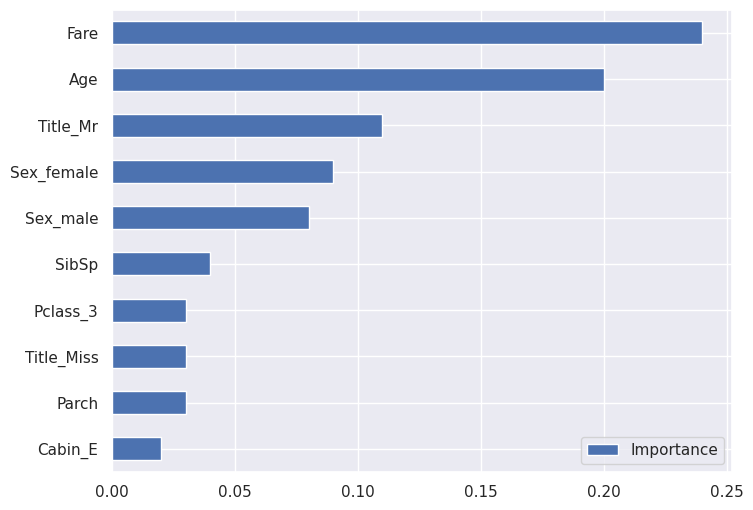

In [68]:
re = ds_boost.feature_importance(model_features, clf_random_forest)